In [74]:
import pandas as pd
import re
import numpy as np
from ast import literal_eval
import seaborn as sns
from matplotlib import pyplot as plt

In [75]:
# read in data
rental_df = pd.read_csv("../data/curated/Scraped_Primary_All_Features.csv")

# number of instances before outlier removal - 11853
len(rental_df)

# drop first two cols (redundant cols confirmed by kalyan)
rental_df = rental_df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1)

# check out data
rental_df.head()

,coordinates,cost_text,postcode,suburb,bedrooms,bathrooms,parking_spaces,house_postcode,nearest_hospital,nearest_train_station,distance_to_cbd,nearest_school
0,"[-37.9032708, 145.0770553]",680.0,3166,hughesdale,3,2,2.0,3166,3.6709,1.3443,18.9780,0.3622
1,"[-37.9077745, 145.092738]",650.0,3166,oakleigh,3,2,2.0,3166,4.4447,1.1150,19.0444,1.2317
2,"[-37.8922004, 145.0899378]",500.0,3166,oakleigh,1,1,1.0,3166,5.7190,1.3874,17.1238,0.4685
3,"[-37.8972564, 145.0871089]",570.0,3166,oakleigh,3,2,2.0,3166,5.0104,0.6788,17.3138,0.4079
4,"[-37.894307, 145.082706]",475.0,3166,hughesdale,2,1,1.0,3166,5.1099,0.6205,17.5619,1.2980


In [76]:
# Ben's Graphing Functions

# Create density plot 
def kde_plot(df, attribute, title, x_label, file_name):
    sns.kdeplot(data=df, x=attribute)
    plt.title(title)
    plt.xlabel(x_label)
    #plt.savefig(file_name + ".png", transparent=True, facecolor="white", bbox_inches="tight")
    plt.show()
    plt.close()

# Continuous Attributes

### Weekly Rent

* Very skewed data, massive outliers exist in the $80k+ range.
* According to Domain.com and Realestate.com, the most expensive suburbs like Toorak and Brighton cap out at weekly rent of about $1100. (Oct. 2021)
* However, to account for raising rental prices and high end estates, the upper limit will be set to $1500p/w

Sources:
* https://www.domain.com.au/news/rents-in-some-of-melbournes-most-expensive-suburbs-are-on-the-rise-1096795/
* https://www.realestate.com.au/news/victorias-most-expensive-rental-suburbs/

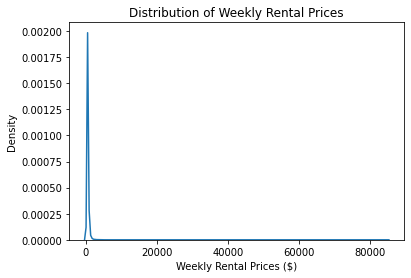

In [77]:
# check initial distribution
kde_plot(rental_df, "cost_text", "Distribution of Weekly Rental Prices", "Weekly Rental Prices ($)", "KDE")

In [78]:
# check number of instances that are above 1500. 125, not alot
print(rental_df[rental_df['cost_text'] > 1500].shape[0])

# remove all rent cost below 0 and greater than 1500
rental_df = rental_df[rental_df['cost_text'].between(0, 1500)]

# num instances remaining - 11728
len(rental_df)

125


11728

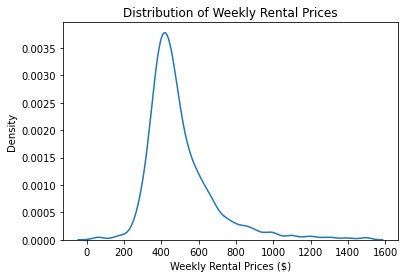

In [79]:
# check distribution again
kde_plot(rental_df, "cost_text", "Distribution of Weekly Rental Prices", "Weekly Rental Prices ($)", "KDE")

### Distance to CBD

* Drive routes calculated by Google Maps was used to estimate the maximum distances
* The longest trip feasible begins at the very North-Western edge of Victoria, **Meringur**, and stretches all the way back to the coordinates of the cbd used for distance api calculation (which is interpreted by Google Maps as Elizabeth Street).
* The length of this trip comes out to **647kms**
* Maximum distance in dataset was about **695kms**
* Since the OSM api assumes the most optimal routes, the discrepency of 48kms between those figures are too great. 10kms is added to account for extreme cases, and therefore, the upper limit for the distance to CBD is deemed to be **657kms**

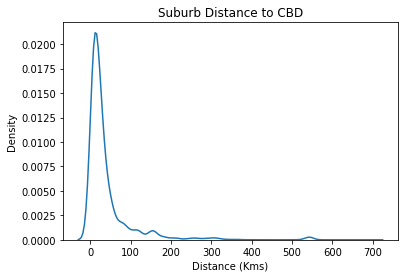

694.5116999999999

In [80]:
# check initial distribution
kde_plot(rental_df, "distance_to_cbd", "Suburb Distance to CBD", "Distance (Kms)", "KDE")

# max value - 694.5kms
rental_df["distance_to_cbd"].max()

In [81]:
# remove all distance below 0 and greater than 657
rental_df = rental_df[rental_df['distance_to_cbd'].between(0, 657)]

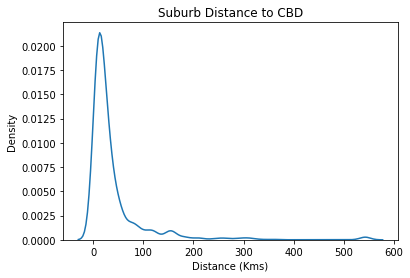

In [82]:
# num instances remaining 11727
len(rental_df)

# check distribution again
kde_plot(rental_df, "distance_to_cbd", "Suburb Distance to CBD", "Distance (Kms)", "KDE")

### Nearest Schools, Hospitals and Train Stations

* **NOTE** without the assistance of some geospatial analysis, it is hard to justify the upper limits of what is considered an outlier. So for now they will be temporarirly chosen by "common sense". E.g. Distances greater than 200kms

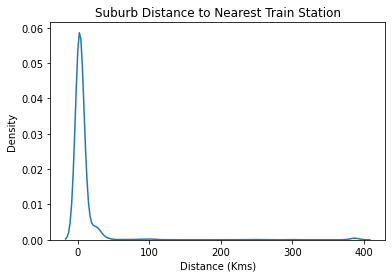

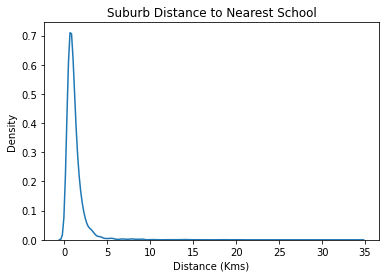

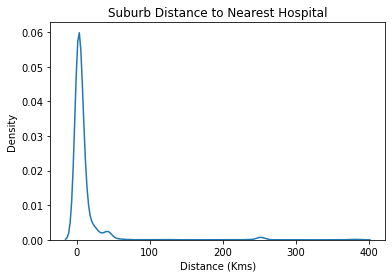

391.0601
34.234300000000005
386.5843


In [83]:
# initial distributions
kde_plot(rental_df, "nearest_train_station", "Suburb Distance to Nearest Train Station", "Distance (Kms)", "KDE")
kde_plot(rental_df, "nearest_school", "Suburb Distance to Nearest School", "Distance (Kms)", "KDE")
kde_plot(rental_df, "nearest_hospital", "Suburb Distance to Nearest Hospital", "Distance (Kms)", "KDE")

# max distances
print(rental_df["nearest_train_station"].max())
print(rental_df["nearest_school"].max())
print(rental_df["nearest_hospital"].max())

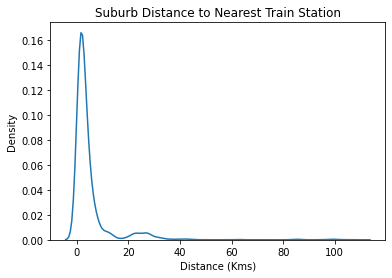

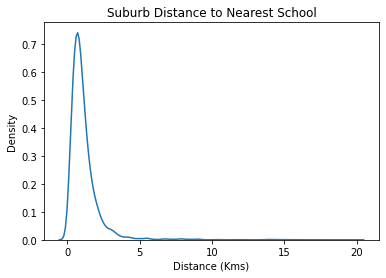

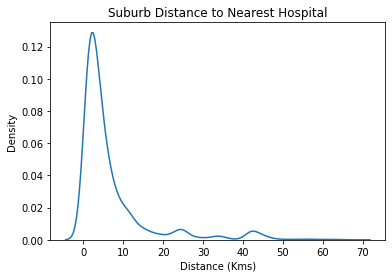

11409

In [84]:
# temp range, by google maps and common sense
rental_df = rental_df[rental_df['nearest_train_station'].between(0, 110)]
rental_df = rental_df[rental_df['nearest_school'].between(0, 20)]
rental_df = rental_df[rental_df['nearest_hospital'].between(0, 70)]

# check distributions again
kde_plot(rental_df, "nearest_train_station", "Suburb Distance to Nearest Train Station", "Distance (Kms)", "KDE")
kde_plot(rental_df, "nearest_school", "Suburb Distance to Nearest School", "Distance (Kms)", "KDE")
kde_plot(rental_df, "nearest_hospital", "Suburb Distance to Nearest Hospital", "Distance (Kms)", "KDE")

# num instances - 11409
len(rental_df)

# Categorial Attributes

### Bedrooms, Bathrooms and Parking Spaces

* Bedrooms, bathrooms and parking spaces range from 0 and to 9, 8, 9 respectively
* To account for rare cases, categorical instances with less than 10 instances are dropped

In [85]:
# Examine initial categories (snippet of Ben's code)
print(sorted(rental_df["bedrooms"].unique()))
print(sorted(rental_df["bathrooms"].unique()))
print(sorted(rental_df["parking_spaces"].unique()))

# REMOVE ALL CATEGORIES WITH LESS THAN 10 INSTANCES
# there are less than 10 instances each for houses with 5 and 8 bathrooms
print(rental_df["bathrooms"].value_counts())
val_bath = [5, 8]
rental_df = rental_df[rental_df.bathrooms.isin(val_bath) == False]

# there are less than 10 instances each for houses with 7, 8 and 9 bedrooms
print(rental_df["bedrooms"].value_counts())
val_bed = [7, 8, 9]
rental_df = rental_df[rental_df.bedrooms.isin(val_bed) == False]

# there are less than 10 instances each for houses with 0, 7, 8 and 9 parking spaces
print(rental_df["parking_spaces"].value_counts())
val_park = [0, 7, 8, 9]
rental_df = rental_df[rental_df.parking_spaces.isin(val_park) == False]

# num instances - 11371
len(rental_df)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 8]
[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
1    6133
2    4762
3     453
4      30
0      22
5       7
8       2
Name: bathrooms, dtype: int64
3    4075
2    3903
4    2084
1    1055
5     189
0      54
6      31
8       3
9       3
7       3
Name: bedrooms, dtype: int64
1.0    6214
2.0    4370
3.0     425
4.0     285
6.0      42
5.0      35
8.0       7
0.0       5
9.0       4
7.0       4
Name: parking_spaces, dtype: int64


11371

### Postcodes

* Postcodes in Victoria range from **3000** to **3996**

Source:
https://www.worldpostalcodes.org/l1/en/au/australia/list/r1/list-of-postcodes-in-victoria


3000
3996


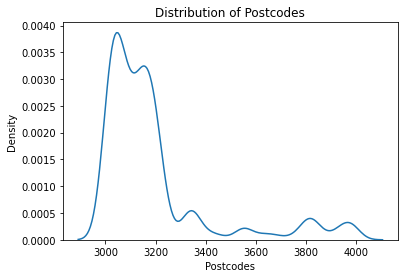

In [86]:
print(rental_df["postcode"].min())
print(rental_df["postcode"].max())
kde_plot(rental_df, "postcode", "Distribution of Postcodes", "Postcodes", "KDE")

* Initial number of instances: **11853**
* Final number of instances: **11371**
* Number of instances discarded: **482**

In [87]:
# check final num instance - 11371
print(len(rental_df))

# check final dataframe
rental_df.head()

# write into csv
rental_df.to_csv('../data/curated/Final_Preprocessed_Scraped_Rental.csv')

11371
